In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import pandas as pd # collection of functions for data processing and analysis modeled after R dataframes with SQL like features
import numpy as np  # foundational package for scientific computing
import re           # Regular expression operations
import matplotlib.pyplot as plt # Collection of functions for scientific and publication-ready visualization
%matplotlib inline
import plotly.offline as py     # Open source library for composing, editing, and sharing interactive data visualization 
from matplotlib import pyplot
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter

# Machine learning libraries
#import xgboost as xgb  # Implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning
import seaborn as sns  # Visualization library based on matplotlib, provides interface for drawing attractive statistical graphics

import sklearn         # Collection of machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, precision_recall_curve, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [0]:
train=pd.read_csv('drive/My Drive/train.csv')
test=pd.read_csv('drive/My Drive/test.csv')

Text(0.5, 1.0, 'Survival Rate by Embarked')

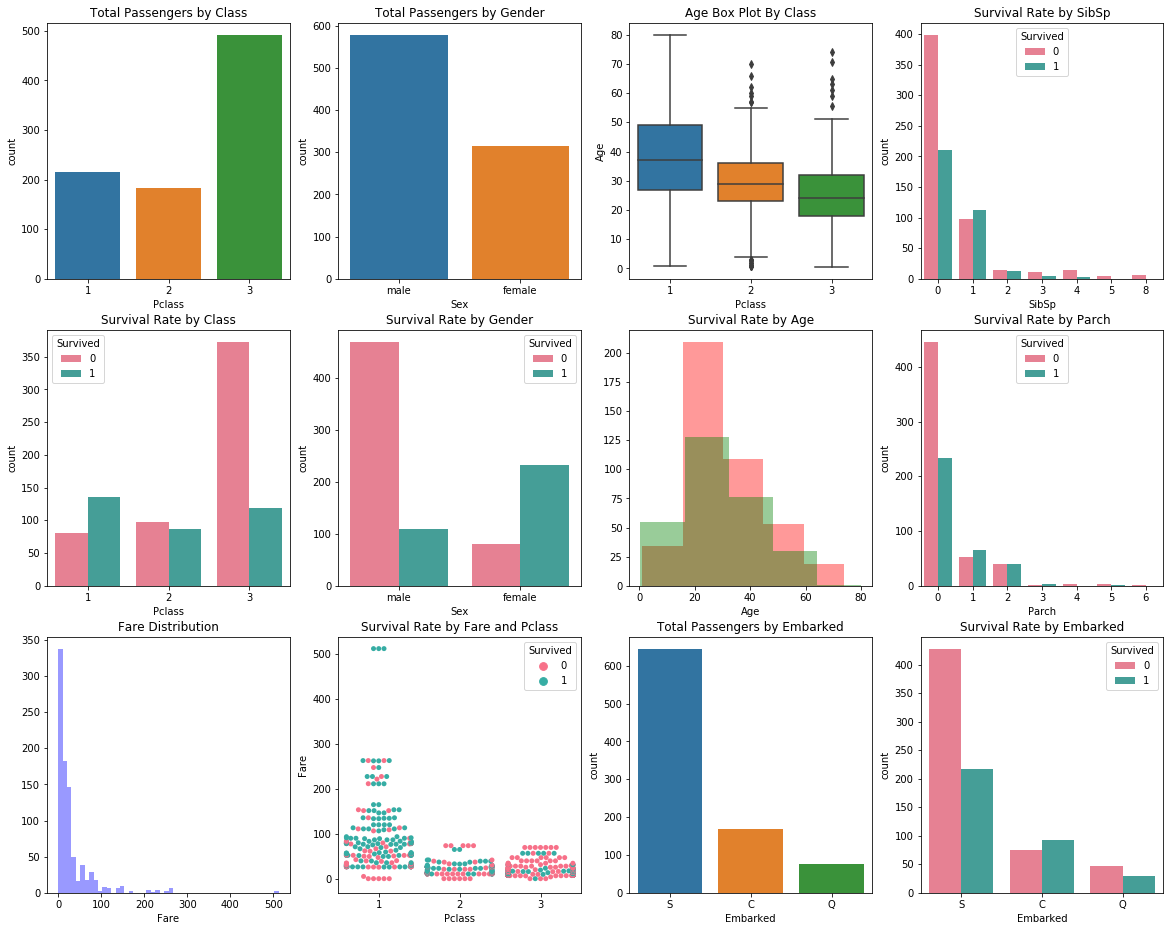

In [4]:


f,ax = plt.subplots(3,4,figsize=(20,16))
sns.countplot('Pclass',data=train,ax=ax[0,0])
sns.countplot('Sex',data=train,ax=ax[0,1])
sns.boxplot(x='Pclass',y='Age',data=train,ax=ax[0,2])
sns.countplot('SibSp',hue='Survived',data=train,ax=ax[0,3],palette='husl')
sns.distplot(train['Fare'].dropna(),ax=ax[2,0],kde=False,color='b')
sns.countplot('Embarked',data=train,ax=ax[2,2])

sns.countplot('Pclass',hue='Survived',data=train,ax=ax[1,0],palette='husl')
sns.countplot('Sex',hue='Survived',data=train,ax=ax[1,1],palette='husl')
sns.distplot(train[train['Survived']==0]['Age'].dropna(),ax=ax[1,2],kde=False,color='r',bins=5)
sns.distplot(train[train['Survived']==1]['Age'].dropna(),ax=ax[1,2],kde=False,color='g',bins=5)
sns.countplot('Parch',hue='Survived',data=train,ax=ax[1,3],palette='husl')
sns.swarmplot(x='Pclass',y='Fare',hue='Survived',data=train,palette='husl',ax=ax[2,1])
sns.countplot('Embarked',hue='Survived',data=train,ax=ax[2,3],palette='husl')

ax[0,0].set_title('Total Passengers by Class')
ax[0,1].set_title('Total Passengers by Gender')
ax[0,2].set_title('Age Box Plot By Class')
ax[0,3].set_title('Survival Rate by SibSp')
ax[1,0].set_title('Survival Rate by Class')
ax[1,1].set_title('Survival Rate by Gender')
ax[1,2].set_title('Survival Rate by Age')
ax[1,3].set_title('Survival Rate by Parch')
ax[2,0].set_title('Fare Distribution')
ax[2,1].set_title('Survival Rate by Fare and Pclass')
ax[2,2].set_title('Total Passengers by Embarked')
ax[2,3].set_title('Survival Rate by Embarked')



In [0]:
This is only a quick of the relationships between features before we start a more detailed analysis.
2. Exploratory Data Analysis (EDA), Cleaning and Engineering features

We will start with a standard approach of any kernel: correct, complete, engineer the right features for analysis.
2.1. Correcting and completing features
Detecting and correcting outliers

Reviewing the data, there does not appear to be any aberrant or non-acceptable data inputs.

There are potential outliers that we will identify (steps from Yassine Ghouzam):

    It creates firset a function called detect_outliers, implementing the Tukey method
    For each column of the dataframe, this function calculates the 25th percentile (Q1) and 75th percentile (Q3) values.
    The interquartile range (IQR) is a measure of statistical dispersion, being equal to the difference between the 75th and 25th percentiles, or between upper and lower quartiles.
    Any data points outside 1.5 time the IQR (1.5 time IQR below Q1, or 1.5 time IQR above Q3), is considered an outlier.
    The outlier_list_col column captures the indices of these outliers. All outlier data get then pulled into the outlier_indices dataframe.
    Finally, the detect_outliers function will select only the outliers happening multiple times. This is the datadframe that will be returned.



In [6]:
# Outlier detection 
# 2.1. Correcting and completing features
def detect_outliers(df,n,features):
    outlier_indices = []
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col],25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index       
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers   
# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])
train.loc[Outliers_to_drop] # Show the outliers rows

PassengerId  Survived  Pclass  ...    Fare        Cabin  Embarked
27            28         0       1  ...  263.00  C23 C25 C27         S
88            89         1       1  ...  263.00  C23 C25 C27         S
159          160         0       3  ...   69.55          NaN         S
180          181         0       3  ...   69.55          NaN         S
201          202         0       3  ...   69.55          NaN         S
324          325         0       3  ...   69.55          NaN         S
341          342         1       1  ...  263.00  C23 C25 C27         S
792          793         0       3  ...   69.55          NaN         S
846          847         0       3  ...   69.55          NaN         S
863          864         0       3  ...   69.55          NaN         S

[10 rows x 12 columns]

In [0]:

Observations

    The Detect_Outliers function found 10 outliers.
    PassengerID 28, 89 and 342 passenger have an high Ticket Fare
    The seven others have very high values of SibSP.
    I found that dropping the outliers actually lower the prediction. So I decided to keep them.

You can try to remove them and rerun the prediction to observe the result with the following function:


In [0]:

Completing features

The .info function below shows how complete or incomplete the datasets are. There are null values or missing data in the age, cabin, and embarked field. Missing values can be bad, because some algorithms don't know how-to handle null values and will fail. While others, like decision trees, can handle null values.

The approach to to complete missing data is to impute using mean, median, or mean + randomized standard deviation. We will do this in section 2.2 with the fillna function: dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())


In [7]:
train.info()
print('_'*40)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

In [0]:
# 2.2. Descriptive analysis (univariate)

full_data = [train, test]
Survival = train['Survived']
Survival.describe()



count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

In [0]:
# 2.3 Feature Engineering - Bi-variate statistical analysis

One of the first tasks in Data Analytics is to convert the variables into numerical/ordinal values. There are multiple types of data

a) Qualitative data: discrete

    Nominal: no natural order between categories. In this case: Name
    Categorical: Sex

b) Numeric or quantitative data

    Discrete: could be ordinal like Pclass or not like Survived.
    Continuous. e.g.: age Many feature engineering steps were taken from Anisotropic's excellent kernel.

Pclass


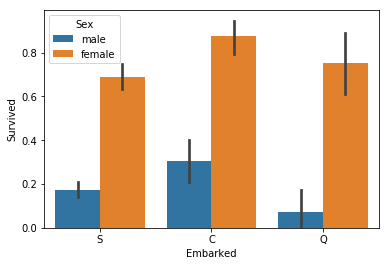

In [0]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=train);



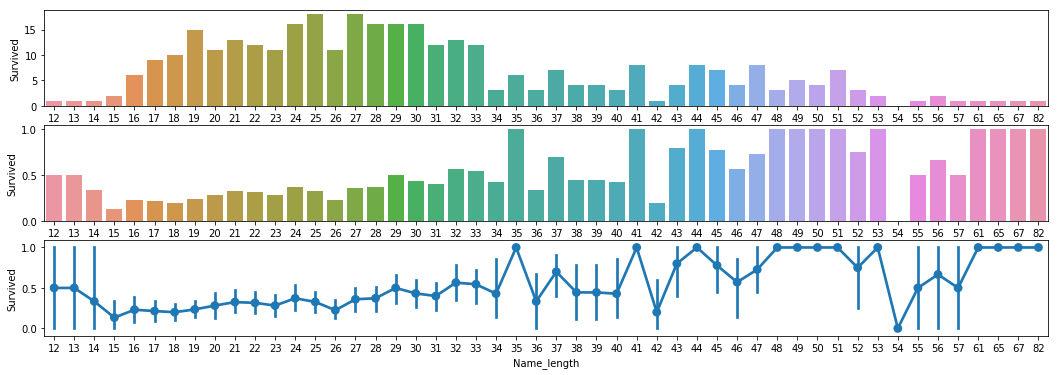

In [0]:
for dataset in full_data:
    dataset['Name_length'] = train['Name'].apply(len)
    # Qcut is a quantile based discretization function to autimatically create categories
    # dataset['Name_length'] = pd.qcut(dataset['Name_length'], 6, labels=False)
    # train['Name_length'].value_counts()

sum_Name = train[["Name_length", "Survived"]].groupby(['Name_length'],as_index=False).sum()
average_Name = train[["Name_length", "Survived"]].groupby(['Name_length'],as_index=False).mean()
fig, (axis1,axis2,axis3) = plt.subplots(3,1,figsize=(18,6))
sns.barplot(x='Name_length', y='Survived', data=sum_Name, ax = axis1)
sns.barplot(x='Name_length', y='Survived', data=average_Name, ax = axis2)
sns.pointplot(x = 'Name_length', y = 'Survived', data=train, ax = axis3)

In [0]:

The first graph shows the amount of people by Name_length.

The second one, their average survival rates.

The proposed categories are: less than 23 (mostly men), 24 to 28, 29 to 40, 41 and more (mostly women). The categories are sized to group passengers with similar Survival rates.


In [0]:
for dataset in full_data:
    dataset.loc[ dataset['Name_length'] <= 23, 'Name_length'] 						            = 0
    dataset.loc[(dataset['Name_length'] > 23) & (dataset['Name_length'] <= 28), 'Name_length']  = 1
    dataset.loc[(dataset['Name_length'] > 28) & (dataset['Name_length'] <= 40), 'Name_length']  = 2
    dataset.loc[ dataset['Name_length'] > 40, 'Name_length'] 							        = 3
train['Name_length'].value_counts()


0    360
1    240
2    201
3     90
Name: Name_length, dtype: int64

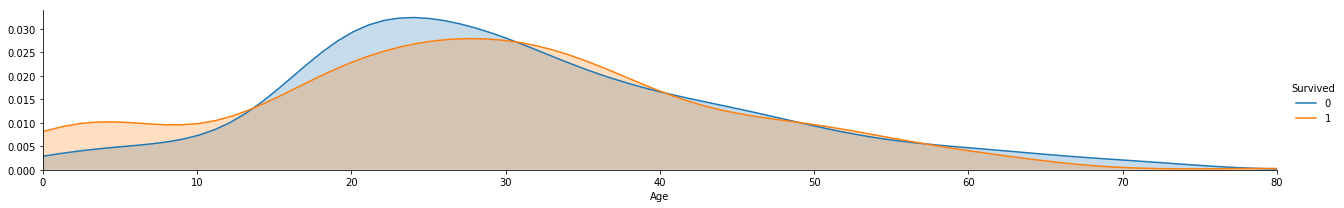

In [0]:
#plot distributions of age of passengers who survived or did not survive
a = sns.FacetGrid( train, hue = 'Survived', aspect=6 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , train['Age'].max()))
a.add_legend()

In [0]:
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
# Qcut is a quantile based discretization function to autimatically create categories (not used here)
# dataset['Age'] = pd.qcut(dataset['Age'], 6, labels=False)
# Using categories as defined above
    dataset.loc[ dataset['Age'] <= 14, 'Age'] 						          = 0
    dataset.loc[(dataset['Age'] > 14) & (dataset['Age'] <= 30), 'Age']        = 5
    dataset.loc[(dataset['Age'] > 30) & (dataset['Age'] <= 40), 'Age']        = 1
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 50), 'Age']        = 3
    dataset.loc[(dataset['Age'] > 50) & (dataset['Age'] <= 60), 'Age']        = 2
    dataset.loc[ dataset['Age'] > 60, 'Age'] 							      = 4
train['Age'].value_counts()

5    426
1    215
3    108
0     78
2     42
4     22
Name: Age, dtype: int64

In [0]:


train[["Age", "Survived"]].groupby(['Age'], as_index=False).mean().sort_values(by='Survived', ascending=False)



Age  Survived
0    0  0.576923
2    2  0.404762
1    1  0.381395
3    3  0.379630
5    5  0.356808
4    4  0.227273

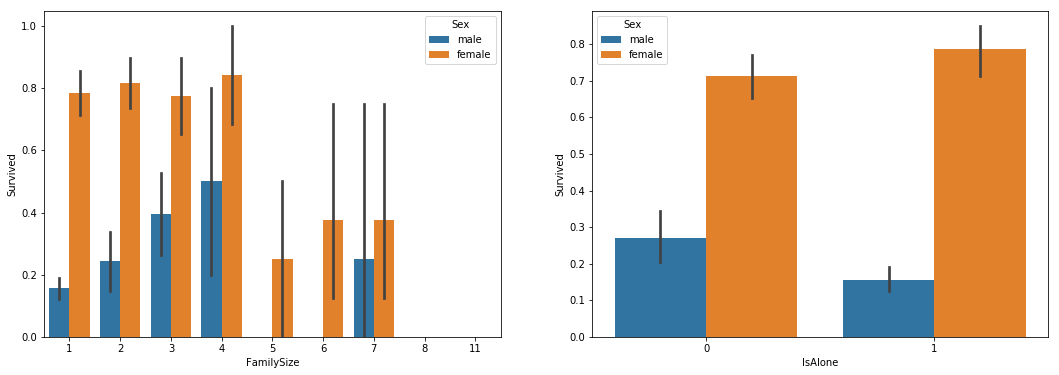

In [0]:
for dataset in full_data:
# Create new feature FamilySize as a combination of SibSp and Parch
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch']+1
# Create new feature IsAlone from FamilySize
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
# Create new feature Boys from FamilySize
    dataset['Boys'] = 0
    dataset.loc[(dataset['Age'] == 0) & (dataset['Sex']==1), 'Boys'] = 1
    
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(18,6))
sns.barplot(x="FamilySize", y="Survived", hue="Sex", data=train, ax = axis1);
sns.barplot(x="IsAlone", y="Survived", hue="Sex", data=train, ax = axis2);

In [0]:


# Interactive chart using cufflinks
import cufflinks as cf
cf.go_offline()
train['Fare'].iplot(kind='hist', bins=30)



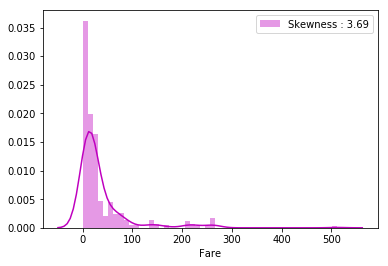

In [0]:
# Remove all NULLS in the Fare column and create a new feature Categorical Fare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# Explore Fare distribution 
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

In [0]:
# Apply log to Fare to reduce skewness distribution
for dataset in full_data:
    dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
a4_dims = (20, 6)
fig, ax = pyplot.subplots(figsize=a4_dims)
g = sns.distplot(train["Fare"][train["Survived"] == 0], color="r", label="Skewness : %.2f"%(train["Fare"].skew()), ax=ax)
g = sns.distplot(train["Fare"][train["Survived"] == 1], color="b", label="Skewness : %.2f"%(train["Fare"].skew()))
#g = g.legend(loc="best")
g = g.legend(["Not Survived","Survived"])

In [0]:
for dataset in full_data:
    dataset.loc[ dataset['Fare'] <= 2.7, 'Fare'] 						      = 0
#    dataset.loc[(dataset['Fare'] > 2.7) & (dataset['Fare'] <= 3.2), 'Fare']   = 1
#    dataset.loc[(dataset['Fare'] > 3.2) & (dataset['Fare'] <= 3.6), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 2.7, 'Fare'] 							  = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
train['Fare'].value_counts()



3    876
0     15
Name: Fare, dtype: int64

In [0]:
# Feature that tells whether a passenger had a cabin on the Titanic (O if no cabin number, 1 otherwise)
for dataset in full_data:
    dataset['Has_Cabin'] = dataset["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

train[["Has_Cabin", "Survived"]].groupby(['Has_Cabin'], as_index=False).sum().sort_values(by='Survived', ascending=False)

Has_Cabin  Survived
0          0       206
1          1       136

In [0]:
train[["Has_Cabin", "Survived"]].groupby(['Has_Cabin'], as_index=False).mean().sort_values(by='Survived', ascending=False)

Has_Cabin  Survived
1          1  0.666667
0          0  0.299854

In [0]:
dataset['Embarked'] = dataset['Embarked'].replace(['0', '2'], '0')
train['Fare'].value_counts()

3    876
0     15
Name: Fare, dtype: int64

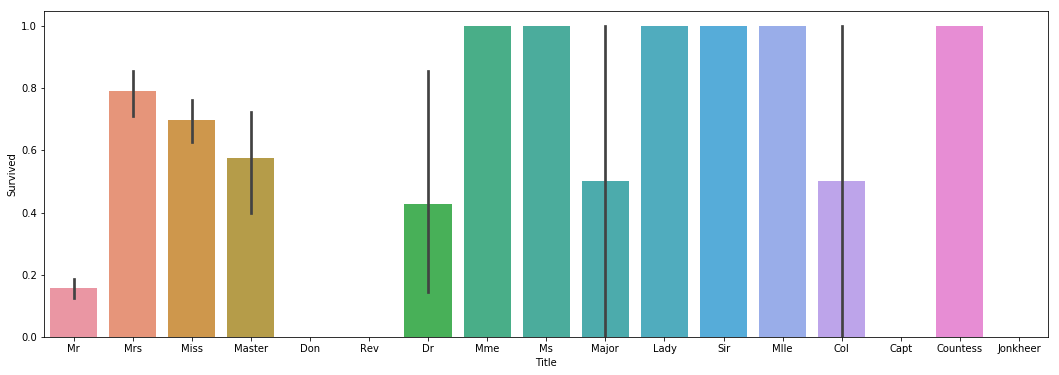

In [0]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
 # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
for dataset in full_data:
# Create a new feature Title, containing the titles of passenger names
    dataset['Title'] = dataset['Name'].apply(get_title)

fig, (axis1) = plt.subplots(1,figsize=(18,6))
sns.barplot(x="Title", y="Survived", data=train, ax=axis1);



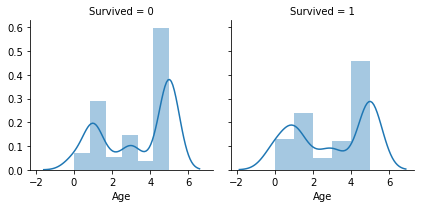

In [0]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Mrs', 'Miss'], 'MM')
    dataset['Title'] = dataset['Title'].replace(['Dr', 'Major', 'Col'], 'DMC')
    dataset['Title'] = dataset['Title'].replace(['Don', 'Rev', 'Capt', 'Jonkheer'],'DRCJ')
    dataset['Title'] = dataset['Title'].replace(['Mme', 'Ms', 'Lady', 'Sir', 'Mlle', 'Countess'],'MMLSMC' )
# Mapping titles
    title_mapping = {"MM": 1, "Master":2, "Mr": 5, "DMC": 4, "DRCJ": 3, "MMLSMC": 0}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(3)
    
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

In [0]:
train[["Title", "Survived"]].groupby(['Title'], as_index=False).mean().sort_values(by='Survived', ascending=False)

Title  Survived
0      0  1.000000
1      1  0.736156
2      2  0.575000
4      4  0.454545
5      5  0.156673
3      3  0.000000

In [0]:
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
for dataset in full_data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int) 
train['Deck'].value_counts()



8    687
3     59
2     47
4     33
5     32
1     15
6     13
7      4
0      1
Name: Deck, dtype: int64

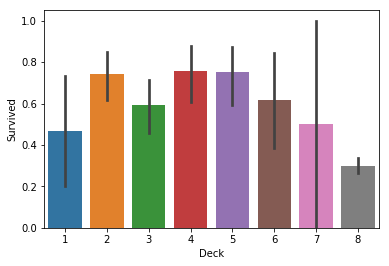

In [0]:
sns.barplot(x = 'Deck', y = 'Survived', order=[1,2,3,4,5,6,7,8], data=train)



In [0]:
for dataset in full_data:
    dataset.loc[ dataset['Deck'] <= 1, 'Deck'] = 1
    dataset.loc[(dataset['Deck'] > 1) & (dataset['Deck'] <= 6), 'Deck']  = 3
    dataset.loc[ dataset['Deck'] > 6, 'Deck'] = 0
train[["Deck", "Survived"]].groupby(['Deck'], as_index=False).mean().sort_values(by='Survived', ascending=False)

Deck  Survived
2     3  0.690217
1     1  0.437500
0     0  0.301013

In [0]:
test.head(5)

PassengerId  Pclass  ... Title  Deck
0          892       3  ...   5.0     0
1          893       3  ...   1.0     0
2          894       2  ...   5.0     0
3          895       3  ...   5.0     0
4          896       3  ...   1.0     0

[5 rows x 18 columns]

In [0]:


train.head(5)



PassengerId  Survived  Pclass  ... Has_Cabin  Title  Deck
0            1         0       3  ...         0      5     0
1            2         1       1  ...         1      1     3
2            3         1       3  ...         0      1     0
3            4         1       1  ...         1      1     3
4            5         0       3  ...         0      5     0

[5 rows x 19 columns]

In [0]:


train.describe()



PassengerId    Survived      Pclass  ...   Has_Cabin       Title        Deck
count   891.000000  891.000000  891.000000  ...  891.000000  891.000000  891.000000
mean    446.000000    0.383838    2.308642  ...    0.228956    3.415264    0.637486
std     257.353842    0.486592    0.836071  ...    0.420397    1.912805    1.213180
min       1.000000    0.000000    1.000000  ...    0.000000    0.000000    0.000000
25%     223.500000    0.000000    2.000000  ...    0.000000    1.000000    0.000000
50%     446.000000    0.000000    3.000000  ...    0.000000    5.000000    0.000000
75%     668.500000    1.000000    3.000000  ...    0.000000    5.000000    0.000000
max     891.000000    1.000000    3.000000  ...    1.000000    5.000000    3.000000

[8 rows x 16 columns]

In [0]:
train[['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'Has_Cabin', 'FamilySize', 'Title', 'Survived']].groupby(['Survived'], as_index=False).mean().sort_values(by='Pclass', ascending=False)

Survived    Pclass       Sex  ...  Has_Cabin  FamilySize     Title
0         0  2.531876  0.852459  ...   0.123862    1.883424  4.273224
1         1  1.950292  0.318713  ...   0.397661    1.938596  2.038012

[2 rows x 10 columns]

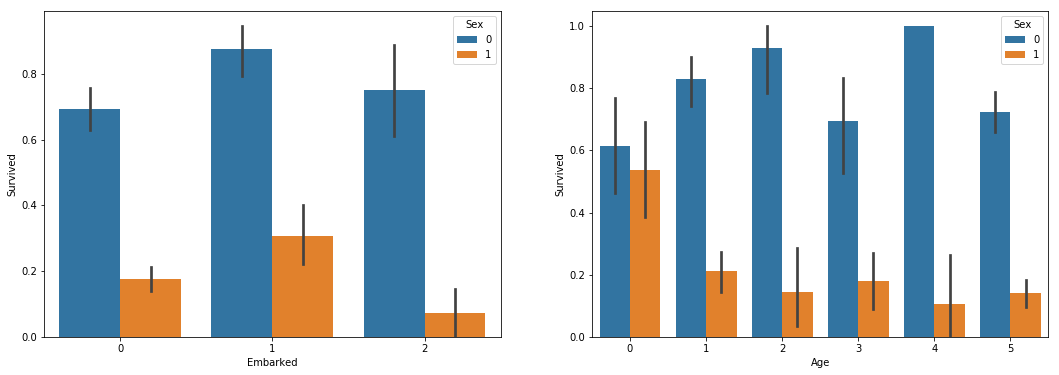

In [0]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(18,6))
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=train, ax = axis1);
sns.barplot(x="Age", y="Survived", hue="Sex", data=train, ax = axis2);

In [0]:
train[["FamilySize", "Survived"]].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

FamilySize  Survived
3           4  0.724138
2           3  0.578431
1           2  0.552795
6           7  0.333333
0           1  0.303538
4           5  0.200000
5           6  0.136364
7           8  0.000000
8          11  0.000000

In [0]:
for dataset in full_data:
    dataset['Gender_Embarked'] = 0
    dataset.loc[(dataset['Sex']==0) & (dataset['Embarked']==0), 'Gender_Embarked'] = 0
    dataset.loc[(dataset['Sex']==0) & (dataset['Embarked']==2), 'Gender_Embarked'] = 1
    dataset.loc[(dataset['Sex']==0) & (dataset['Embarked']==1), 'Gender_Embarked'] = 2
    dataset.loc[(dataset['Sex']==1) & (dataset['Embarked']==2), 'Gender_Embarked'] = 3
    dataset.loc[(dataset['Sex']==1) & (dataset['Embarked']==0), 'Gender_Embarked'] = 4
    dataset.loc[(dataset['Sex']==1) & (dataset['Embarked']==1), 'Gender_Embarked'] = 5
train[["Gender_Embarked", "Survived"]].groupby(['Gender_Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

Gender_Embarked  Survived
2                2  0.876712
1                1  0.750000
0                0  0.692683
5                5  0.305263
4                4  0.174603
3                3  0.073171

In [0]:


train_pivot = pd.pivot_table(train, values= 'Survived',index=['Title', 'Pclass'],columns='Sex',aggfunc=np.mean, margins=True)
def color_negative_red(val):
    # Takes a scalar and returns a string with the css property 'color: red' if below 0.4, black otherwise.
    color = 'red' if val < 0.4 else 'black'
    return 'color: %s' % color
train_pivot = train_pivot.style.applymap(color_negative_red)
train_pivot



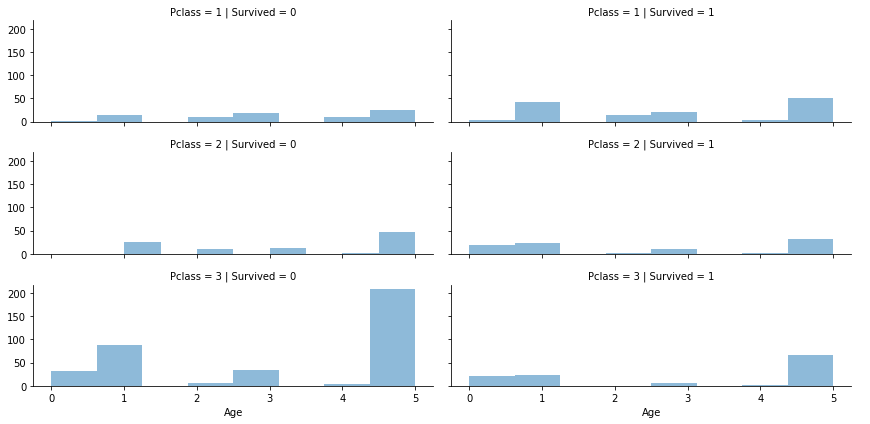

In [0]:


# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(train, col='Survived', row='Pclass', size=2, aspect=3)
grid.map(plt.hist, 'Age', alpha=.5, bins=8)
grid.add_legend();



Text(0.5, 1.0, 'Pclass vs Family Size Survival Comparison')

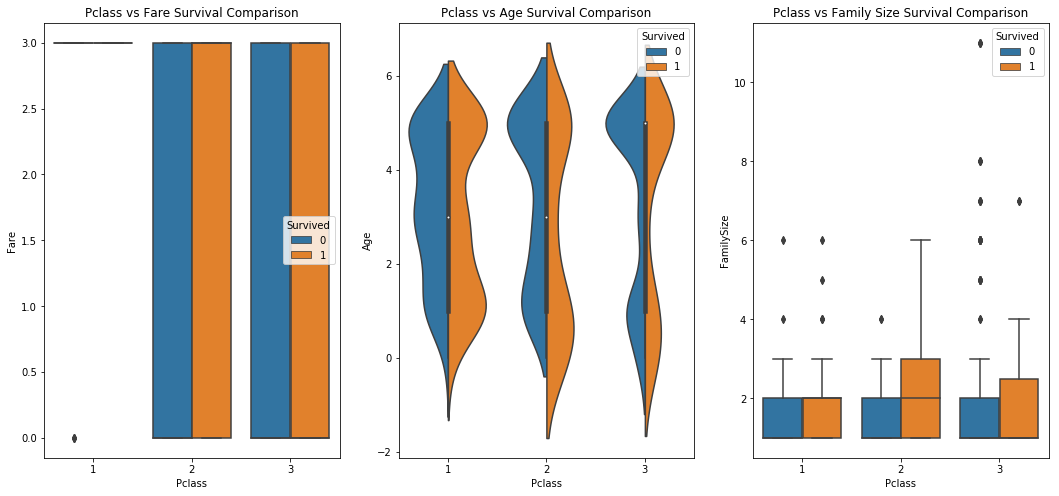

In [0]:
#graph distribution of qualitative data: Pclass
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(18,8))

sns.boxplot(x = 'Pclass', y = 'Fare', hue = 'Survived', data = train, ax = axis1)
axis1.set_title('Pclass vs Fare Survival Comparison')

sns.violinplot(x = 'Pclass', y = 'Age', hue = 'Survived', data = train, split = True, ax = axis2)
axis2.set_title('Pclass vs Age Survival Comparison')

sns.boxplot(x = 'Pclass', y ='FamilySize', hue = 'Survived', data = train, ax = axis3)
axis3.set_title('Pclass vs Family Size Survival Comparison')

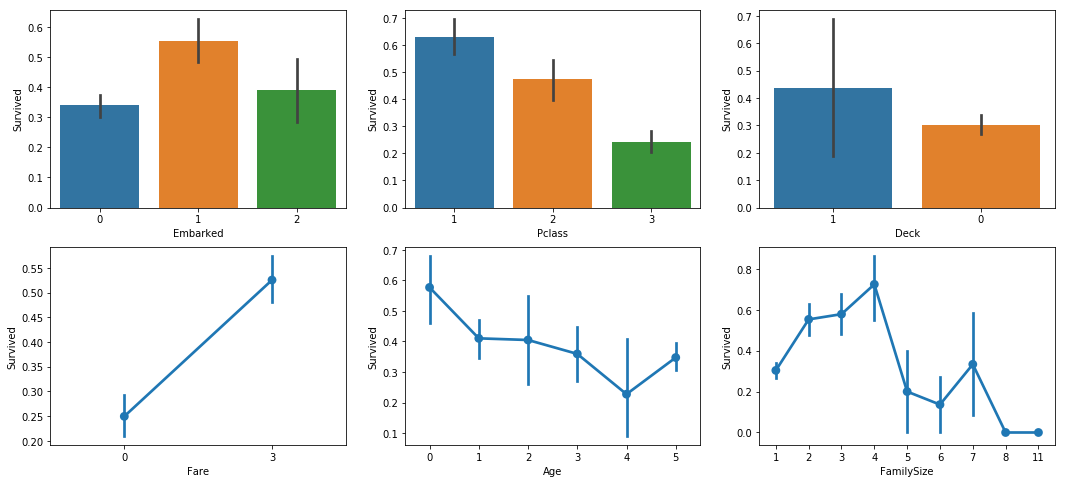

In [0]:
fig, saxis = plt.subplots(2, 3,figsize=(18,8))

sns.barplot(x = 'Embarked', y = 'Survived', data=train, ax = saxis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived', order=[1,2,3], data=train, ax = saxis[0,1])
sns.barplot(x = 'Deck', y = 'Survived', order=[1,0], data=train, ax = saxis[0,2])

sns.pointplot(x = 'Fare', y = 'Survived',  data=train, ax = saxis[1,0])
sns.pointplot(x = 'Age', y = 'Survived',  data=train, ax = saxis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived', data=train, ax = saxis[1,2])

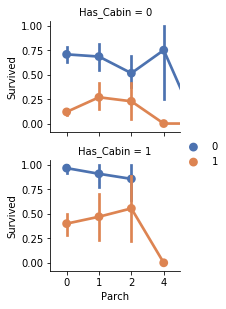

In [0]:
# grid = sns.FacetGrid(train_df, col='Embarked')
grid = sns.FacetGrid(train, row='Has_Cabin', size=2.2, aspect=1.2)
grid.map(sns.pointplot, 'Parch', 'Survived', 'Sex', palette='deep')
grid.add_legend()

In [0]:


# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Boys', 'IsAlone', 'Embarked']

train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)



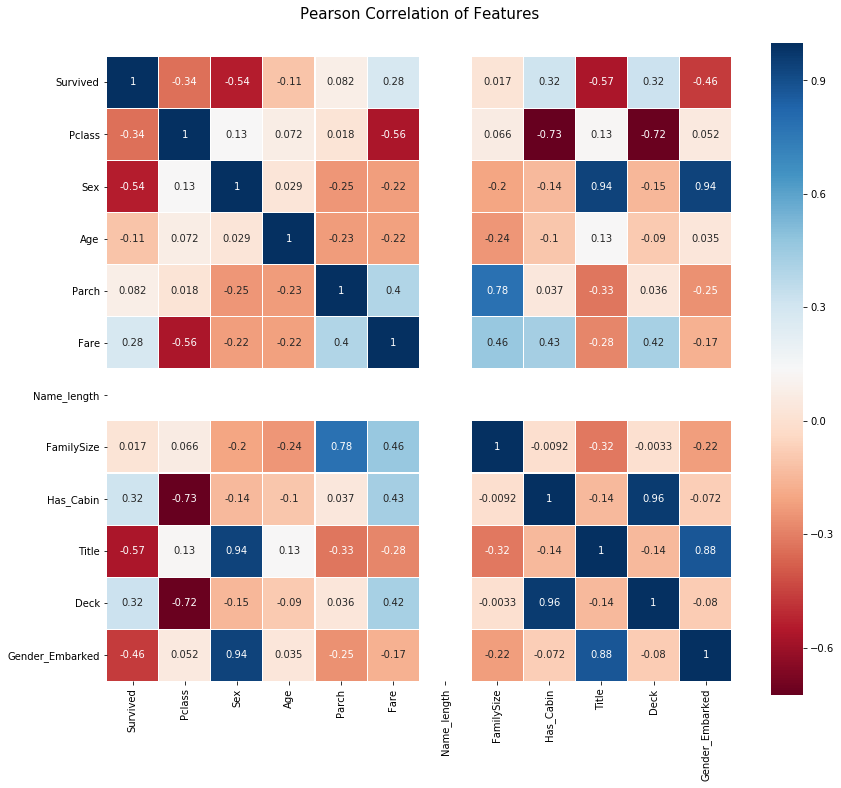

In [0]:

# 3.3. Pearson Correlation Heatmap

# The Seaborn plotting package allows us to plot heatmaps showing the Pearson product-moment correlation coefficient (PPMCC) correlation between features. Pearson is bivariate correlation, measuring the linear correlation between two features.

colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)



## **Logistic Regression **

In [0]:

# X_train (all features for training purpose but excluding Survived),
# Y_train (survival result of X-Train) and test are our 3 main datasets for the next sections
X_train = train.drop("Survived", axis=1)
Y_train = train["Survived"]
X_train.shape, Y_train.shape, test.shape

X_train, x_test, Y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3, random_state=101)

X_test = test.copy() # test data for Kaggle submission
#std_scaler = StandardScaler()
#X_train = std_scaler.fit_transform(X_train)
#X_test = std_scaler.transform(X_test)


In [0]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred1 = logreg.predict(x_test)
acc_log = round(logreg.score(x_test, y_test) * 100, 2)
acc_log



80.6

In [0]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, Y_pred1))
cm = pd.DataFrame(confusion_matrix(y_test, Y_pred1), ['Actual: NOT', 'Actual: SURVIVED'], ['Predicted: NO', 'Predicted: SURVIVED'])
print(cm)

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       154
           1       0.84      0.68      0.75       114

    accuracy                           0.81       268
   macro avg       0.81      0.79      0.79       268
weighted avg       0.81      0.81      0.80       268

                  Predicted: NO  Predicted: SURVIVED
Actual: NOT                 139                   15
Actual: SURVIVED             37                   77


# **Support Vector Machine **

In [0]:
svc=SVC()
svc.fit(X_train, Y_train)
Y_pred2 = svc.predict(x_test)
acc_svc = round(svc.score(x_test, y_test) * 100, 2)
acc_svc



80.22

In [0]:
print(classification_report(y_test, Y_pred2))
cm = pd.DataFrame(confusion_matrix(y_test, Y_pred2), ['Actual: NOT', 'Actual: SURVIVED'], ['Predicted: NO', 'Predicted: SURVIVED'])
print(cm)

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       154
           1       0.84      0.67      0.74       114

    accuracy                           0.80       268
   macro avg       0.81      0.78      0.79       268
weighted avg       0.81      0.80      0.80       268

                  Predicted: NO  Predicted: SURVIVED
Actual: NOT                 139                   15
Actual: SURVIVED             38                   76


# **K-Nearest Neighbour **

In [0]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski', 
                           metric_params=None, n_jobs=1, n_neighbors=10, p=2, 
                           weights='uniform')
knn.fit(X_train, Y_train)
knn_predictions = knn.predict(x_test)
acc_knn = round(knn.score(x_test, y_test) * 100, 2)
acc_knn

79.48

In [0]:
print(classification_report(y_test, knn_predictions))
cm = pd.DataFrame(confusion_matrix(y_test, knn_predictions), ['Actual: NOT', 'Actual: SURVIVED'], ['Predicted: NO', 'Predicted: SURVIVED'])
print(cm)



              precision    recall  f1-score   support

           0       0.77      0.91      0.84       154
           1       0.84      0.64      0.73       114

    accuracy                           0.79       268
   macro avg       0.81      0.77      0.78       268
weighted avg       0.80      0.79      0.79       268

                  Predicted: NO  Predicted: SURVIVED
Actual: NOT                 140                   14
Actual: SURVIVED             41                   73


In [0]:
## Selecting the right n_neighbors for the k-NN classifier
x_trainknn, x_testknn, y_trainknn, y_testknn = train_test_split(X_train,Y_train,test_size = .33, random_state = 0)
nn_scores = []
best_prediction = [-1,-1]
for i in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance', metric='minkowski', p =2)
    knn.fit(x_trainknn, y_trainknn)
    score = accuracy_score(y_testknn, knn.predict(x_testknn))
    #print i, score
    if score > best_prediction[1]:
        best_prediction = [i, score]
    nn_scores.append(score)
print (best_prediction)
plt.plot(range(1,100),nn_scores)



# **Naive Bayes **

In [0]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred3 = gaussian.predict(x_test)
acc_gaussian = round(gaussian.score(x_test, y_test) * 100, 2)
acc_gaussian

76.12

In [0]:
print(classification_report(y_test, Y_pred3))
cm = pd.DataFrame(confusion_matrix(y_test, Y_pred3), ['Actual: NOT', 'Actual: SURVIVED'], ['Predicted: NO', 'Predicted: SURVIVED'])
print(cm)

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       154
           1       0.70      0.75      0.73       114

    accuracy                           0.76       268
   macro avg       0.76      0.76      0.76       268
weighted avg       0.76      0.76      0.76       268

                  Predicted: NO  Predicted: SURVIVED
Actual: NOT                 118                   36
Actual: SURVIVED             28                   86


# **Perceptron **

In [0]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred4 = perceptron.predict(x_test)
acc_perceptron = round(perceptron.score(x_test, y_test) * 100, 2)
acc_perceptron



78.73

In [0]:
print(classification_report(y_test, Y_pred4))
cm = pd.DataFrame(confusion_matrix(y_test, Y_pred4), ['Actual: NOT', 'Actual: SURVIVED'], ['Predicted: NO', 'Predicted: SURVIVED'])
print(cm)

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       154
           1       0.83      0.63      0.72       114

    accuracy                           0.79       268
   macro avg       0.80      0.77      0.77       268
weighted avg       0.79      0.79      0.78       268

                  Predicted: NO  Predicted: SURVIVED
Actual: NOT                 139                   15
Actual: SURVIVED             42                   72


# **Decision Tree**

In [0]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred7 = decision_tree.predict(x_test)
acc_decision_tree = round(decision_tree.score(x_test, y_test) * 100, 2)
acc_decision_tree

79.1

In [0]:
print(classification_report(y_test, Y_pred7))
cm = pd.DataFrame(confusion_matrix(y_test, Y_pred7), ['Actual: NOT', 'Actual: SURVIVED'], ['Predicted: NO', 'Predicted: SURVIVED'])
print(cm)

              precision    recall  f1-score   support

           0       0.77      0.91      0.83       154
           1       0.84      0.62      0.71       114

    accuracy                           0.79       268
   macro avg       0.80      0.77      0.77       268
weighted avg       0.79      0.79      0.78       268

                  Predicted: NO  Predicted: SURVIVED
Actual: NOT                 140                   14
Actual: SURVIVED             43                   71


# **Random Forest**

In [0]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
random_forest_predictions = random_forest.predict(x_test)
acc_random_forest = round(random_forest.score(x_test, y_test) * 100, 2)
acc_random_forest

80.6

In [0]:
print(classification_report(y_test, random_forest_predictions))
cm = pd.DataFrame(confusion_matrix(y_test, random_forest_predictions), ['Actual: NOT', 'Actual: SURVIVED'], ['Predicted: NO', 'Predicted: SURVIVED'])
print(cm)

              precision    recall  f1-score   support

           0       0.78      0.92      0.85       154
           1       0.86      0.65      0.74       114

    accuracy                           0.81       268
   macro avg       0.82      0.79      0.79       268
weighted avg       0.81      0.81      0.80       268

                  Predicted: NO  Predicted: SURVIVED
Actual: NOT                 142                   12
Actual: SURVIVED             40                   74


# **SGD**

In [0]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred6 = sgd.predict(x_test)
acc_sgd = round(sgd.score(x_test, y_test) * 100, 2)
acc_sgd

74.25

In [0]:
print(classification_report(y_test, Y_pred6))
cm = pd.DataFrame(confusion_matrix(y_test, Y_pred6), ['Actual: NOT', 'Actual: SURVIVED'], ['Predicted: NO', 'Predicted: SURVIVED'])
print(cm)

              precision    recall  f1-score   support

           0       0.83      0.69      0.75       154
           1       0.66      0.82      0.73       114

    accuracy                           0.74       268
   macro avg       0.75      0.75      0.74       268
weighted avg       0.76      0.74      0.74       268

                  Predicted: NO  Predicted: SURVIVED
Actual: NOT                 106                   48
Actual: SURVIVED             21                   93


# **Linear SVC**

In [0]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred5 = linear_svc.predict(x_test)
acc_linear_svc = round(linear_svc.score(x_test, y_test) * 100, 2)
acc_linear_svc

80.22

In [0]:
print(classification_report(y_test, Y_pred5))
cm = pd.DataFrame(confusion_matrix(y_test, Y_pred5), ['Actual: NOT', 'Actual: SURVIVED'], ['Predicted: NO', 'Predicted: SURVIVED'])
print(cm)



              precision    recall  f1-score   support

           0       0.80      0.88      0.84       154
           1       0.81      0.69      0.75       114

    accuracy                           0.80       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268

                  Predicted: NO  Predicted: SURVIVED
Actual: NOT                 136                   18
Actual: SURVIVED             35                   79


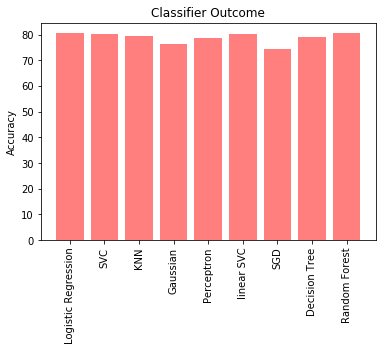

In [0]:
objects = ('Logistic Regression', 'SVC', 'KNN', 'Gaussian', 'Perceptron', 'linear SVC', 'SGD', 'Decision Tree', 'Random Forest')
x_pos = np.arange(len(objects))
accuracies1 = [acc_log, acc_svc, acc_knn, acc_gaussian, acc_perceptron, acc_linear_svc, acc_sgd, acc_decision_tree, acc_random_forest]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='r')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('Accuracy')
plt.title('Classifier Outcome')
plt.show()

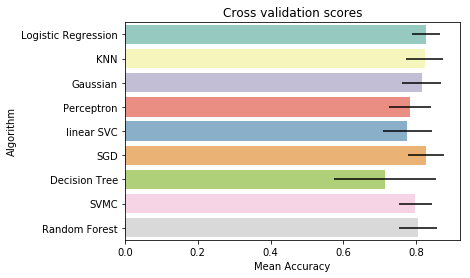

In [0]:
# Cross validate model with Kfold stratified cross validation
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10)
# Modeling step Test differents algorithms 
random_state = 2

classifiers = []
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(GaussianNB())
classifiers.append(Perceptron(random_state=random_state))
classifiers.append(LinearSVC(random_state=random_state))
classifiers.append(SGDClassifier(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state = random_state))
classifiers.append(RandomForestClassifier(random_state = random_state))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":['Logistic Regression',  'KNN', 'Gaussian',
    'Perceptron', 'linear SVC', 'SGD', 'Decision Tree','SVMC', 'Random Forest']})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [0]:
# Adaboost
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)
ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}
gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsadaDTC.fit(X_train,Y_train)
adaDTC_best = gsadaDTC.best_estimator_
gsadaDTC.best_score_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  83 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    7.2s finished


0.8105939004815409

In [0]:
# ExtraTrees 
ExtC = ExtraTreesClassifier()
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 7],
              "min_samples_split": [2, 3, 7],
              "min_samples_leaf": [1, 3, 7],
              "bootstrap": [False],
              "n_estimators" :[300,600],
              "criterion": ["gini"]}
gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsExtC.fit(X_train,Y_train)
ExtC_best = gsExtC.best_estimator_
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.5min finished


0.8394863563402889

In [0]:
# Gradient boosting tunning
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] }
gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsGBC.fit(X_train,Y_train)
GBC_best = gsGBC.best_estimator_
gsGBC.best_score_



Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   20.2s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   38.6s finished


0.8330658105939005

In [0]:
# Random Forest
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 7],
              "min_samples_split": [2, 3, 7],
              "min_samples_leaf": [1, 3, 7],
              "bootstrap": [False],
              "n_estimators" :[300,600],
              "criterion": ["gini"]}
gsrandom_forest = GridSearchCV(random_forest,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsrandom_forest.fit(X_train,Y_train)
# Best score
random_forest_best = gsrandom_forest.best_estimator_
gsrandom_forest.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   54.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.8min finished


0.841091492776886

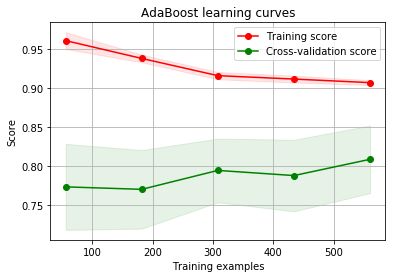

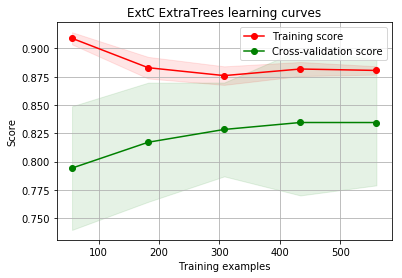

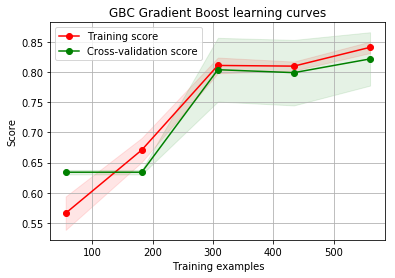

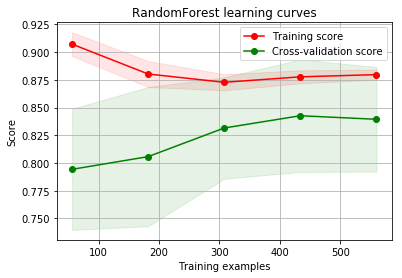

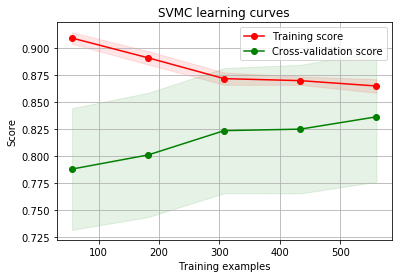

In [0]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtC ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GBC Gradient Boost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsrandom_forest.best_estimator_,"RandomForest learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVMC learning curves",X_train,Y_train,cv=kfold)